# Description of the final project

## Introduction

This project is devoted to the question-answering task. You are going to work with the **BoolQ** dataset from SuperGLUE .

BoolQ is a question answering dataset for yes/no. 

Each example is a triplet of (question, passage, answer), with the title of the page as optional additional context. The dataset release consists of three `.jsonl` files (`train, val, test`), where each line is a JSON dictionary with the following format:

    Example:
    
    {
      "question": "is france the same timezone as the uk",
      "passage": "At the Liberation of France in the summer of 1944, Metropolitan France kept GMT+2 as it was the time then used by the Allies (British Double Summer Time). In the winter of 1944--1945, Metropolitan France switched to GMT+1, same as in the United Kingdom, and switched again to GMT+2 in April 1945 like its British ally. In September 1945, Metropolitan France returned to GMT+1 (pre-war summer time), which the British had already done in July 1945. Metropolitan France was officially scheduled to return to GMT+0 on November 18, 1945 (the British returned to GMT+0 in on October 7, 1945), but the French government canceled the decision on November 5, 1945, and GMT+1 has since then remained the official time of Metropolitan France."
      "answer": false,
      "title": "Time in France",
    }

For this project you will need only `train` and `val` parts.

Dataset is available here: https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip

Detailed task description is available here: https://arxiv.org/abs/1905.10044

## Bonus for those, who want to work with Russian

For those who want to work with Russian data there is an option to use **DaNetQA** dataset (instead of BoolQ) from Russsian SuperGLUE. The dataset is organised similarly to BoolQ.

You may download data from here: https://russiansuperglue.com/tasks/download/DaNetQA

Detailed task description is available here: https://arxiv.org/abs/2010.02605


**Note:** note that you should take only one dataset (either BoolQ or DanetQA). There are no bonus points for solving both tasks.


## Detailed Task Description

In the task you should perform all the model training on `train.jsonl` data and evaluate your models on `val.jsonl`. Note that you do not need `test.jsonl`.

Use **accuracy metric** for scoring.

The solution of either BoolQ or DaNetQA should include:


### [10%] 1. Data analysis 


* 1.1  (10%) Download the data and calculate basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.) and make visualizations, if necessary. 


### [40%] 2. Pretrained embeddings as features for classifier
* 2.1 (5%) Take pre-trained word2vec or fastText embeddings and vectorize your data using them.

**Note:** you may use any pre-trained embeddings available on the Internet. For example, for English you may take GoogleNews vectors, which are available here: https://www.kaggle.com/leadbest/googlenewsvectorsnegative300 . For the Russian language you may choose one of the models from RusVectores (https://rusvectores.org/ru/models/).

* 2.2  (15%) Use pretrained embeddings as features to a classifier. Train SVM, Linear Regression or any other classification model. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).

* 2.3 (5%) Instead of word2vec or fastText embeddings get BERT embeddings from the train dataset and vectorize your data. 

**Note:** you may use any of the BERT-like models from hugging face (https://huggingface.co/) library. For example, you may use `bert-base-multilingual-cased` (https://huggingface.co/bert-base-multilingual-cased).

* 2.4  (15%) Similarly to 2.1, train SVM, Linear Regression or any other classification model using BERT embeddings as features for a classifier. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).


### [40%] 3. Fine-tune BERT

* 3.1 (10%) Split the data from `train.jsonl` into train and dev (dev_size = 10%) . Tokenize and format the data (do not forget about the [SEP] token).

* 3.2   (10%) Initialize the model, optimizer and learning rate scheduler. Explain your choice of the parameters.

* 3.3   (10%) Write a training loop and fine-tune BERT. Do to forget about evaluation on dev set created in 3.1. 

**Note:** you may use one of the tutorials for fine-tuning BERT, but you have to provide a link to it. For example, you may use this one: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

* 3.4   (10%)  Make predictions for the test data (from `val.jsonl`),  and analyze the results (use accuracy metric for scoring).



### [10%] 4. Summary & results analysis


* 4.1    (5%) Compare the results of all the tested models and try to interpret them.

* 4.2    (5%) Propose, how you may improve the model score (write at least three ideas).


### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Provide links to the tutorials you use for reference.


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.8 MB/s 
     |████████████████████████████████| 7.6 MB 49.4 MB/s 
     |████████████████████████████████| 163 kB 31.6 MB/s 


In [4]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import re
import os

import torch
from transformers import BertModel, BertTokenizer
from gensim import models
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import train_test_split


%matplotlib inline

1. Data Analysis

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
main_folder = '/content/drive/MyDrive/HSE_NLP'
train_file = main_folder + '/train.jsonl'
val_file = main_folder + '/val.jsonl'

In [7]:
!head /content/drive/MyDrive/HSE_NLP/train.jsonl

{"question": "do iran and afghanistan speak the same language", "passage": "Persian language -- Persian (/\u02c8p\u025c\u02d0r\u0292\u0259n, -\u0283\u0259n/), also known by its endonym Farsi (\u0641\u0627\u0631\u0633\u06cc f\u0101rsi (f\u0252\u02d0\u027e\u02c8si\u02d0) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.", "idx": 0, "label": true}
{"question": "do good samaritan laws protect those who help at an accident", "passage": "Good Samaritan law -- Good Samaritan laws offer legal protection to people who give reasonable assistance to th

In [8]:
df_train = pd.read_json(train_file, lines=True, orient='records')
df_train.head(3)

,question,passage,idx,label
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",0,True
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,1,True
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,2,True


In [9]:
df_val = pd.read_json(val_file, lines=True, orient='records', encoding = 'utf-8')
df_val.tail(3)

,question,passage,idx,label
3267,are there plants on the international space st...,Plants in space -- Plant research continued on...,3267,True
3268,does the hockey puck have to cross the line to...,"Goal (ice hockey) -- In ice hockey, a goal is ...",3268,True
3269,will there be a season 5 of shadowhunters,List of Shadowhunters episodes -- In April 201...,3269,False


In [10]:
print('Number of train exmaples: ', len(df_train))
print('Number of validation exmaples: ', len(df_val))

Number of train exmaples:  9427
Number of validation exmaples:  3270


In [11]:
df_train['y'] = np.where(df_train['label']==True, 1, 0)
df_val['y'] = np.where(df_val['label']==True, 1, 0)

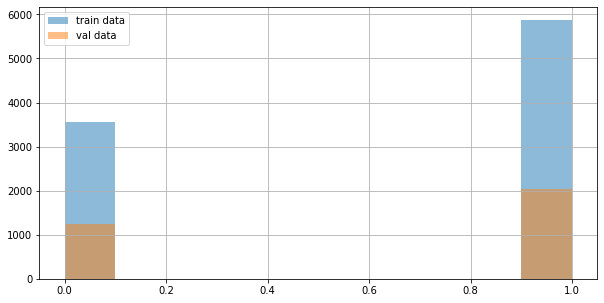

In [12]:
# we have more positive exmaples than negative in both datasets
plt.figure(figsize=(10, 5))
plt.hist(df_train['y'], label=f"train data", alpha = 0.5)
plt.hist(df_val['y'], label=f"val data", alpha = 0.5)
plt.grid()
plt.legend()
plt.show()

In [13]:
df_train['passage_len'] = df_train['passage'].apply(lambda x: len(x))
df_val['passage_len'] = df_val['passage'].apply(lambda x: len(x))

In [14]:
print('Average len of passage in train dataset: ', round(df_train.passage_len.mean(), 2))
print('Average len of passage in validation dataset: ', round(df_val.passage_len.mean(),2))

Average len of passage in train dataset:  590.17
Average len of passage in validation dataset:  583.31


In [15]:
def words_only(text):
    text = re.sub(r'[\W]+', ' ', text)
    text = re.sub(r'--', ' ', text)
    text = re.sub('\s+', ' ',text)
    text = re.sub(r'\\','', text)
    text = text.lower().strip()
    return text.split(' ')


df_train['passage_clean'] = df_train['passage'].apply(words_only)

df_train['question_clean'] = df_train['question'].apply(words_only)



In [16]:
df_train.head()

,question,passage,idx,label,y,passage_len,passage_clean,question_clean
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",0,True,1,606,"[persian, language, persian, ˈpɜːrʒən, ʃən, al...","[do, iran, and, afghanistan, speak, the, same,..."
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,1,True,1,840,"[good, samaritan, law, good, samaritan, laws, ...","[do, good, samaritan, laws, protect, those, wh..."
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,2,True,1,332,"[windows, movie, maker, windows, movie, maker,...","[is, windows, movie, maker, part, of, windows,..."
3,is confectionary sugar the same as powdered sugar,"Powdered sugar -- Powdered sugar, also called ...",3,True,1,461,"[powdered, sugar, powdered, sugar, also, calle...","[is, confectionary, sugar, the, same, as, powd..."
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online -- As with other game...,4,False,0,926,"[the, elder, scrolls, online, as, with, other,...","[is, elder, scrolls, online, the, same, as, sk..."


In [17]:
df_val['passage_clean'] = df_val['passage'].apply(words_only)
df_val['question_clean'] = df_val['question'].apply(words_only)

In [18]:
df_val.head()

,question,passage,idx,label,y,passage_len,passage_clean,question_clean
0,does ethanol take more energy make that produces,Ethanol fuel -- All biomass goes through at le...,0,False,0,1384,"[ethanol, fuel, all, biomass, goes, through, a...","[does, ethanol, take, more, energy, make, that..."
1,is house tax and property tax are same,Property tax -- Property tax or 'house tax' is...,1,True,1,1227,"[property, tax, property, tax, or, house, tax,...","[is, house, tax, and, property, tax, are, same]"
2,is pain experienced in a missing body part or ...,Phantom pain -- Phantom pain sensations are de...,2,True,1,352,"[phantom, pain, phantom, pain, sensations, are...","[is, pain, experienced, in, a, missing, body, ..."
3,is harry potter and the escape from gringotts ...,Harry Potter and the Escape from Gringotts -- ...,3,True,1,601,"[harry, potter, and, the, escape, from, gringo...","[is, harry, potter, and, the, escape, from, gr..."
4,is there a difference between hydroxyzine hcl ...,Hydroxyzine -- Hydroxyzine preparations requir...,4,True,1,367,"[hydroxyzine, hydroxyzine, preparations, requi...","[is, there, a, difference, between, hydroxyzin..."


In [19]:

def unique_words_count(data):
  unique_set = set()
  for x in data:
      for y in x:
          unique_set.add(y)
  return len(unique_set)

print("Number of unique words in train dataset: ", unique_words_count(df_train['passage_clean']))
print("Number of unique words in validation dataset: ", unique_words_count(df_val['passage_clean']))

Number of unique words in train dataset:  42463
Number of unique words in validation dataset:  25046


2. Pretrained embeddings as features for classifier

In [20]:
pretrained_embeddings_path = "/content/drive/MyDrive/HSE_NLP/GoogleNews-vectors-negative300.bin"
word2vec = models.KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

In [ ]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 300 ## YOUR CODE HERE

    def fit(self, X, y):
        return self

    def transform(self, X):      
        ### YOUR CODE HERE
        return np.array([
            np.mean([self.word2vec[w] for w in X if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
        ])

In [ ]:
vectorizer = MeanEmbeddingVectorizer(word2vec)

train_passage_vec = np.array([vectorizer.transform(x)[0] for x in df_train['passage_clean'].values])
train_question_vec = np.array([vectorizer.transform(x)[0] for x in df_train['question_clean'].values])

val_passage_vec = np.array([vectorizer.transform(x)[0] for x in df_val['passage_clean'].values])
val_question_vec = np.array([vectorizer.transform(x)[0] for x in df_val['question_clean'].values])

In [ ]:
X_train = np.hstack((train_passage_vec, train_question_vec))
X_val = np.hstack((val_passage_vec, val_question_vec))

y_train = df_train['y']
y_val = df_val['y']


In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
y_pred = clf.predict(X_val)

We received low accuracy score using this basic method (word2vec embeddings + SVM classifier)

In [ ]:
print("SVM accuracy score is: ", accuracy_score(y_val, y_pred))

SVM accuracy score is:  0.653822629969419


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')

token_embedding = {token: bert.get_input_embeddings()(torch.tensor(id))  for token, id in tokenizer.get_vocab().items()}


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class BertMeanEmbeddingVectorizer(object):
    def __init__(self, emb_model):
        self.bert = emb_model
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 768 ## YOUR CODE HERE

    def fit(self, X, y):
        return self

    def transform(self, X):
        
        ### YOUR CODE HERE
        return np.array([
            np.mean([self.bert[w].detach().numpy() for w in X if w in self.bert]
                    or [np.zeros(self.dim)], axis=0)
        ])

In [ ]:
vectorizer = BertMeanEmbeddingVectorizer(token_embedding)

train_passage_vec_bert = np.array([vectorizer.transform(x)[0] for x in df_train['passage_clean'].values])
train_question_vec_bert = np.array([vectorizer.transform(x)[0] for x in df_train['question_clean'].values])

val_passage_vec_bert = np.array([vectorizer.transform(x)[0] for x in df_val['passage_clean'].values])
val_question_vec_bert = np.array([vectorizer.transform(x)[0] for x in df_val['question_clean'].values])

In [ ]:
X_train = np.hstack((train_passage_vec_bert, train_question_vec_bert))
X_val = np.hstack((val_passage_vec_bert, val_question_vec_bert))

BERT embeddings produced better accuracy score but increase is small. I tried muli-lingual model and received lower score. English embeddings seem to work better.

In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print("SVM accuracy score is: ", accuracy_score(y_val, y_pred))

SVM accuracy score is:  0.6773700305810397


3. Fine-tune BERT

In [21]:
df_train['text'] = df_train['question'] + ' ' + df_train['passage']
df_val['text'] = df_val['question'] + ' ' + df_val['passage']

In [22]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [23]:
# Get the lists of sentences and their labels.
sentences = df_train.text.values
labels = df_train.y.values

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (914 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  914


In [25]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True,
                        max_length = 512,           # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [26]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,484 training samples
  943 validation samples


In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [28]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        res = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss = res['loss']
        logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            res = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )


print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    266.    Elapsed: 0:00:29.
  Batch    80  of    266.    Elapsed: 0:00:57.
  Batch   120  of    266.    Elapsed: 0:01:25.
  Batch   160  of    266.    Elapsed: 0:01:53.
  Batch   200  of    266.    Elapsed: 0:02:21.
  Batch   240  of    266.    Elapsed: 0:02:50.

  Average training loss: 0.64
  Training epcoh took: 0:03:07

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.60
  Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    266.    Elapsed: 0:00:28.
  Batch    80  of    266.    Elapsed: 0:00:56.
  Batch   120  of    266.    Elapsed: 0:01:24.
  Batch   160  of    266.    Elapsed: 0:01:52.
  Batch   200  of    266.    Elapsed: 0:02:20.
  Batch   240  of    266.    Elapsed: 0:02:48.

  Average training loss: 0.54
  Training epcoh took: 0:03:06

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.59
  Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
 

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.64,0.60,0.67,0:03:07,0:00:07
2,0.54,0.59,0.70,0:03:06,0:00:07
3,0.43,0.60,0.71,0:03:06,0:00:07
4,0.32,0.68,0.72,0:03:06,0:00:07


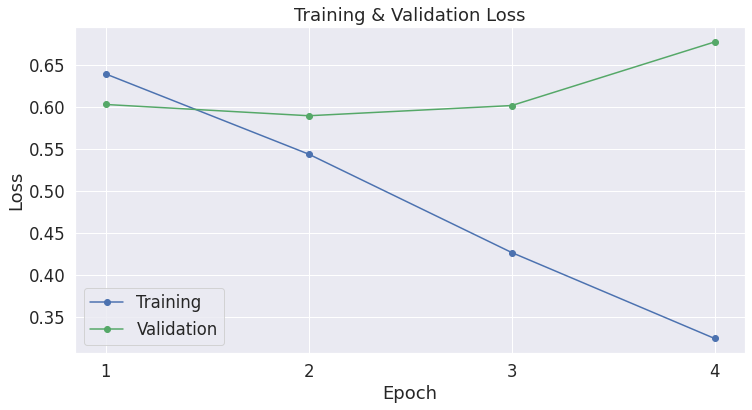

In [ ]:
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Create sentence and label lists
sentences = df_val.text.values
labels = df_val.y.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        truncation=True,
                        padding='max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,270 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df_val.y.sum(), len(df_val.y), (df_val.y.sum() / len(df_val.y) * 100.0)))

Positive samples: 2033 of 3270 (62.17%)


In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)


In [ ]:
from sklearn.metrics import *
accuracy_score(flat_true_labels, flat_predictions)

0.7137614678899082

4. Summary & results analysis

We see increase in accuracy as we go from word2vec embedding to BERT embedding with SVM model because BERT embeddings were created on larger corpus of texts.

We see additional increase in accuracy when we go to fine-tuned BERT model from SVM because BERT is SOTA model for NLP and designed to handle NLP tasks better than generic SVM model.

Given limited size of the dataset, we can't increate performance by training our own BERT model. We can achieve small increase in accuracy by tuning optimizer parameters  (I tried to change learning rate but it did not increase accuracy; we can add rate decay), trying different optimizers, controlling how data is cleaned and how data is truncated during tokenization. We can also try different pretrained BERT models. I tried muli-lingiual model but results were worse than all English model.

Model seems to be overfitting based on validation stats (validation loss is increasing). I tried smaller number of epochs but this did not chanage results.
